### Human voice to Robot voice

In [16]:
# %pip install soundfile scipy numpy pywavelets librosa matplotlib simpleaudio

In [17]:
import soundfile as sf
import numpy as np
import pandas as pd 
import pywt
import librosa
import wave
import simpleaudio as sa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython.display as ipd
from scipy.signal import butter, lfilter, filtfilt

Function to plot the signal

In [18]:
# Plot the signal
def plotSignal(filename):
    with wave.open(filename, 'rb') as wav_file:
        # Extract the signal and the sample rate
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype='int16')
        fs = wav_file.getframerate()

    # Compute the time vector
    time = np.arange(signal.size) / fs

    # Plot the waveform
    plt.plot(time, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform of {}".format(filename))
    plt.show()

Load source voice and target voice signals

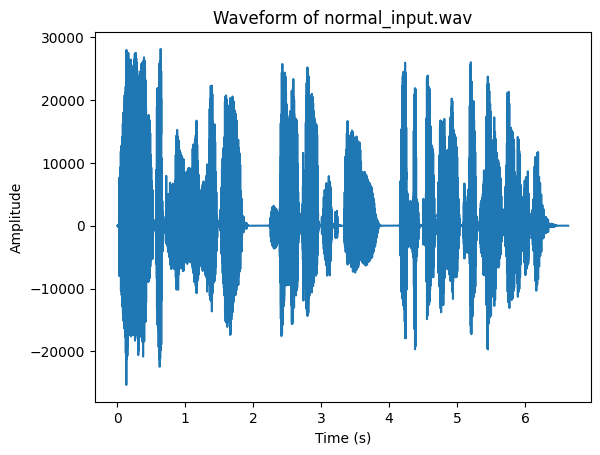

normal_input.wav:


In [19]:
# Load the WAV file
fs, signal = wav.read('normal_input.wav')

plotSignal("normal_input.wav")

print("normal_input.wav:")
ipd.Audio("normal_input.wav")

Perform Noise filtering

In [20]:
# Define the filter parameters
cutoff_freq = 1000  # Hz
filter_order = 5

# Create a Butterworth filter
nyquist_freq = 0.5 * fs
cutoff = cutoff_freq / nyquist_freq
b, a = butter(filter_order, cutoff, btype="highpass")

In [21]:
# Apply the filter to the signal
filtered_signal = lfilter(b, a, signal)

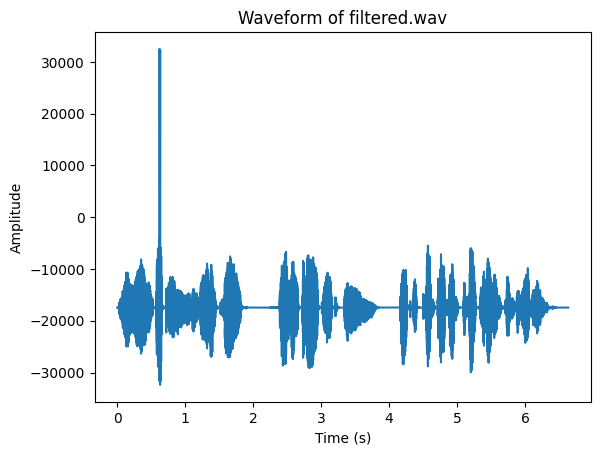

filtered.wav:


In [22]:
# Save the filtered signal to a new WAV file
wav.write("filtered.wav", fs, ((filtered_signal + filtered_signal.min()) * (2 ** 15) / filtered_signal.ptp()).astype(np.int16))

plotSignal("filtered.wav")

print("filtered.wav:")
ipd.Audio("filtered.wav")

## Feature Extraction

Perform Discrete Transform

In [23]:
# Load the filtered WAV file
fs, signal = wav.read('filtered.wav')

# Define the wavelet to use and the number of decomposition levels
wavelet = 'db4'
levels = 5

# Perform the discrete wavelet transform
coeffs = pywt.wavedec(signal, wavelet, level=levels)

# Get the approximation coefficients (i.e., the reconstructed low-pass component)
approx = pywt.upcoef('a', coeffs[0], wavelet, level=levels, take=len(signal))

# # Save the approximation coefficients to a new WAV file
# wav.write("approximation.wav", fs, ((approx + approx.min()) * (2 ** 15) / approx.ptp()).astype(np.int16))

Divide the generated approximation wav file into small frames of fixed time period

In [24]:
# Load the filtered WAV file
fs, signal = wav.read('filtered.wav')

# Define the frame length and hop length in seconds
frame_length = 0.1  # seconds
hop_length = 0.023   # seconds

# Convert the frame and hop lengths to samples
frame_length_samples = int(frame_length * fs)
hop_length_samples = int(hop_length * fs)

# Divide the signal into frames
frames = librosa.util.frame(signal, frame_length=frame_length_samples, hop_length=hop_length_samples)

In [25]:
# Save each frame to a separate WAV file
# for i, frame in enumerate(frames):
#     filename = f"./frames/frame_{i+1}.wav"
#     wav.write(filename, fs, frame)

frames, len(frames), frames.shape[1]

(array([[-17457, -17456, -17752, ..., -17457, -17457, -17455],
        [-17457, -17517, -17831, ..., -17458, -17457, -17457],
        [-17457, -17554, -17806, ..., -17459, -17458, -17457],
        ...,
        [-16571, -21209, -17303, ..., -17457, -17457, -17457],
        [-15742, -20909, -16308, ..., -17457, -17457, -17457],
        [-15676, -19556, -15290, ..., -17457, -17456, -17457]], dtype=int16),
 4410,
 285)

Estimate fundamental frequency of each frame using auto correlation

In [26]:
# Initialize an empty list to hold the fundamental frequencies
f0s = []

# Iterate over each frame
for i, frame in enumerate(frames):
    # Compute the autocorrelation of the frame
    autocorr = np.correlate(frame, frame, mode='full')
    
    # Get the positive half of the autocorrelation
    autocorr_pos = autocorr[len(autocorr)//2:]
    
    # Find the index of the maximum value in the positive half of the autocorrelation
    peak_index = np.argmax(autocorr_pos)
    
    # Convert the peak index to a frequency value in Hz
    f0 = fs / peak_index
    
    # Append the fundamental frequency to the list
    f0s.append(f0)

C:\Users\aksha\AppData\Local\Temp\ipykernel_19504\3422636090.py:16: RuntimeWarning: divide by zero encountered in longlong_scalars
  f0 = fs / peak_index


Extract the frequency and bandwidth using cepstral analysis method

In [27]:
# Set the order of the cepstral analysis
order = 10

# Initialize an empty array to hold the frequency and bandwidth information for each frame
freq_band = np.zeros((frames.shape[1], 2))

In [28]:
# Iterate over each frame
for i in range(frames.shape[1]):
    # Apply pre-emphasis to the frame
    pre_emphasis = librosa.effects.preemphasis(frames[:, i].astype(np.float32))

    # Compute the power spectrum of the pre-emphasized frame
    power_spectrum = np.abs(np.fft.fft(pre_emphasis)) ** 2

    # Compute the logarithm of the power spectrum
    log_power_spectrum = np.log(power_spectrum)

    # Compute the cepstrum of the logarithm of the power spectrum
    cepstrum = np.real(np.fft.ifft(log_power_spectrum))

    # Set the coefficients of the cepstrum beyond the order to zero
    cepstrum[order+1:] = 0

    # Compute the inverse Fourier transform of the modified cepstrum
    modified_power_spectrum = np.exp(np.fft.fft(cepstrum))
    modified_power_spectrum[0] = 0

    # Find the index of the maximum value in the modified power spectrum
    max_index = np.argmax(modified_power_spectrum)

    # Convert the index to a frequency value in Hz
    freq = fs / max_index

    # Compute the bandwidth of the peak in the modified power spectrum
    bandwidth = fs / np.sum(modified_power_spectrum > 0.5 * np.max(modified_power_spectrum))

    # Store the frequency and bandwidth information for the frame
    freq_band[i, :] = [freq, bandwidth]

Compute spectral envelope using lpc method

In [29]:
# Apply pre-emphasis filter
signal = librosa.effects.preemphasis(signal.astype(np.float32), 0.95)

In [30]:
# Initialize an empty list to hold the spectral envelopes
spectral_envelopes = []

# Iterate over each frame
for i in range(frames.shape[1]):
    # Get the current frame
    frame = frames[:, i]
    
    # Apply window to the frame
    frame_windowed = frame * np.hamming(frame_length_samples)
    
    # Compute the LPC coefficients using autocorrelation method
    lpc_coeffs = librosa.lpc(frame_windowed, order)
    
    # Compute the roots of the LPC polynomial to obtain the poles
    poles = np.roots(lpc_coeffs)
    
    # Convert the poles to frequencies
    freqs = np.arctan2(poles.imag, poles.real) * (fs / (2*np.pi))
    
    # Compute the magnitude of the poles to obtain the spectral envelope
    mags = np.abs(lfilter(lpc_coeffs, [1], np.exp(-2j*np.pi*freqs/fs)))
    
    # Normalize the spectral envelope
    mags /= mags.max()
    
    # Append the spectral envelope to the list
    spectral_envelopes.append(mags)

Concatenate extracted features of each frame into a feature vector

In [31]:
# Concatenate the spectral envelopes of each frame into a feature vector
feature_vector = np.hstack(spectral_envelopes)

feature_vector, len(feature_vector)

(array([0.01619951, 0.07179501, 0.18032806, ..., 0.93788147, 0.70357152,
        0.4296071 ]),
 2850)

## Voice Synthesis

Apply signal processing techniques (phase vocoder)

In [32]:
# # Load the approximation WAV file
# fs, signal = wav.read("approximation.wav")
signal, fs = librosa.load("filtered.wav", sr=None, mono=True)

# Convert the frame and hop lengths to samples
frame_length_samples = int(frame_length * fs)
hop_length_samples = int(hop_length * fs)

# Apply pre-emphasis filter
signal_preemphasized = librosa.effects.preemphasis(signal, 0.95)

# Define the speed-up factor
speed_up_factor = 2

# Apply phase vocoder
spectrogram = librosa.stft(signal_preemphasized)
spectrogram_stretched = librosa.phase_vocoder(spectrogram, speed_up_factor, hop_length=hop_length_samples)

Combine synthesized frames into continuous waveform

In [33]:
# Combine synthesized frames into continuous waveform
frames_stretched = librosa.istft(spectrogram_stretched, hop_length=hop_length_samples)
signal_stretched = librosa.effects.preemphasis(frames_stretched, coef=0.95)

Apply post-processing (filtering/normalization)

In [34]:
# Transpose the signal back to its original shape
transposed_signal_stretched = signal_stretched.T

# Apply a high-pass filter to remove any DC offset
b, a = butter(1, 30, 'highpass', fs=fs)
signal_filtered = filtfilt(b, a, transposed_signal_stretched)

# # Normalize the signal
signal_normalized = librosa.util.normalize(signal_filtered)

Save synthesized voice as a audio file

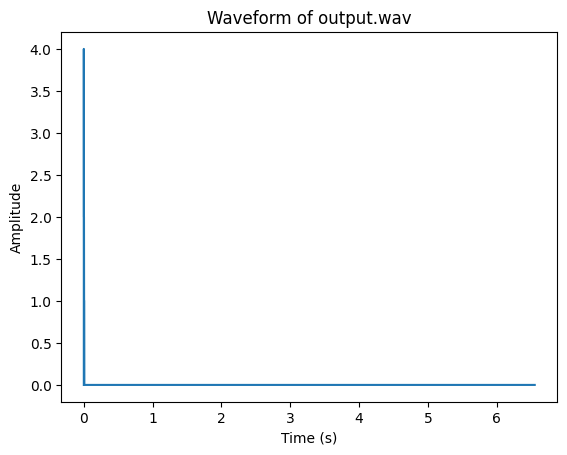

output.wav:


In [35]:
# Write the stretched and filtered signal to a WAV file
wav.write("output.wav", fs, np.real(signal_filtered).astype(np.int16))

plotSignal("output.wav")

print("output.wav:")
ipd.Audio("output.wav")

In [36]:
# # Load the original and synthesized audio files
# fs, original_audio = wav.read("normal_input.wav")
# fs, synthesized_audio = wav.read("output.wav")

# # Calculate the SNR
# noise = original_audio - synthesized_audio
# signal_power = np.sum(original_audio**2)
# noise_power = np.sum(noise**2)
# snr = 10 * np.log10(signal_power / noise_power)

# print("SNR:", snr)